# Supplement - Near-wake length, $x_0$
This notebook recreates Figure 2 in the supplementary material. This figure shows how the near-wake length varies with $C-T'$, and compares against large eddy simulations as well as the unified momentum model excluding the nonlinear pressure contribution term.

In [1]:
from pathlib import Path
from typing import List, Optional, Dict, Union, Tuple
from dataclasses import dataclass
import itertools
import os

import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from scipy.io import loadmat


from UnifiedMomentumModel import Momentum


# Use Latex Fonts
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

lesdir = Path(os.getcwd()) / "LES_data"
figdir = Path(os.getcwd()).parent / "fig"
figdir.mkdir(exist_ok=True, parents=True)
figdir_eps = figdir / "eps"
figdir_eps.mkdir(exist_ok=True, parents=True)

# Collect data to compare
Data to compared is collected in a dictionary of lists of `MomentumSolution` objects (`Dict[str, List[MomentumSolution]]`)

## Load LES Data
We first load the LES data into a `MomentumSolution`-like object. First we define this object:

In [2]:
@dataclass
class LESSolution:
    """
    Stores the results from LES solutions for later comparison with Unified
    Momentum solution.
    """

    Ctprime: float
    an: float
    u4: float
    v4: float
    x0: float
    dp: float
    Cp: float
    Ct: float
    dp_NL: Optional[float] = 0.0
    niter: Optional[int] = 1
    converged: Optional[bool] = True
    beta: Optional[float] = 0.0


MomentumSolutionLike = Union[Momentum.MomentumSolution, LESSolution]

In [3]:
# Set up results dictionary
results: Dict[str, List[MomentumSolutionLike]] = {}

In [4]:
def load_LES_data_ctp(filename: Path) -> List[LESSolution]:
    data = loadmat(filename)

    out = []
    for Cp, Ct, Ctp, p4, a, u4, x0 in zip(
        data["Cp_ctp_input"][0],
        data["Ct_ctp_input"][0],
        data["Ctp_vector"][0],
        data["P4_ctp_input"][0],
        data["a_ctp_input"][0],
        data["u4_ctp_input"][0],
        data["x0_ctp_input"][0],
    ):
        # Remove large x0 values
        if x0 >= 5.1:
            x0 = np.nan
        out.append(LESSolution(Ctp, a, u4, 0, x0, p4, Cp, Ct))

    return out


def load_LES_data_ct(filename: Path) -> List[LESSolution]:
    data = loadmat(filename)
    out = []
    for Cp, Ct, p4, a, u4, x0 in zip(
        data["Cp_ct_input"][0],
        data["Ct_ct_input"][0],
        data["P4_ct_input"][0],
        data["a_ct_input"][0],
        data["u4_ct_input"][0],
        data["x0_ct_input_positive_Ct_only"][0],
    ):
        Ctp = Ct / (1 - a) ** 2

        # Remove large x0 values
        if x0 >= 5.1:
            x0 = np.nan

        # Remove LES points with infeasable induction values
        if a < 1.1:
            out.append(LESSolution(Ctp, a, u4, 0, x0, p4, Cp, Ct))
    return out


def load_LES_data_NREL(filename: Path) -> List[LESSolution]:
    df = pl.read_csv(
        filename, has_header=False, columns=[0, 1], new_columns=["a", "Ct"]
    )
    out = []

    for a, ct in df.iter_rows():
        out.append(LESSolution(np.nan, a, np.nan, np.nan, np.nan, np.nan, np.nan, ct))
    return out


# Load LES
LES_data_fn = lesdir / "LES_streamtube_data.mat"
NREL_LES_data_fn = lesdir / "ct_data_les_tony.txt"

results["LES_ctp"] = load_LES_data_ctp(LES_data_fn)
results["LES_ct"] = load_LES_data_ct(LES_data_fn)
results["LES_NREL"] = load_LES_data_NREL(NREL_LES_data_fn)

# Generate Model Data

In [5]:
models_to_compare = {
    "linear": Momentum.UnifiedMomentum(cached=False, max_iter=0),
    "nonlinear": Momentum.UnifiedMomentum(),
    "nonlinear_minus": Momentum.UnifiedMomentum(beta=0.9 * 0.1403),
    "nonlinear_plus": Momentum.UnifiedMomentum(beta=1.1 * 0.1403),
}
Ctprimes = np.concatenate(
    [np.linspace(-2, 12, 100), np.linspace(12, 4000, 400), [100000]]
)


# Run unified model and variations
for name, model in models_to_compare.items():
    results[name] = []
    for Ctprime in Ctprimes:
        results[name].append(model(Ctprime, 0))

# Plotting

In [6]:
plot_kwargs = {
    "LES_ctp": dict(ls="", marker=".", ms=8, c="0.5", label="LES (MIT) $C_T'$ input"),
    "LES_ct": dict(ls="", marker=".", ms=8, c="b", label="LES (MIT) $C_T$ input"),
    "LES_NREL": dict(
        ls="", marker="d", ms=2, c="tab:pink", label="LES (NREL) $C_T$ input"
    ),
    "classical": dict(c="r", label="Classical Model"),
    "linear": dict(label="Unified model (linear pressure only)"),
    "nonlinear": dict(c="k", lw=2, label="Unified model"),
}

plot_order = [
    "classical",
    # "linear",
    "LES_ctp",
    "LES_ct",
    "nonlinear",
    "LES a priori",
    "LES_NREL",
]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


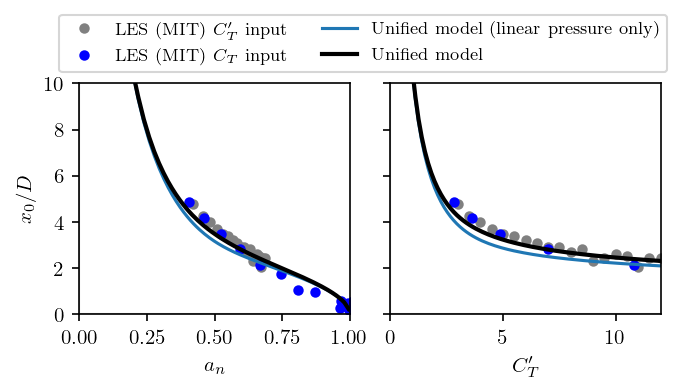

In [7]:
fig, axes = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(5, 2), dpi=150)
plt.subplots_adjust(wspace=0.15, hspace=0.15)


# Plot lines
keys = ["LES_ctp", "LES_ct", "linear", "nonlinear"]
for name in keys:
    sol_list = results[name]

    _plot_kwargs = plot_kwargs[name] if name in plot_kwargs else {}

    ch1_val = [getattr(sol, "x0") for sol in sol_list]

    Ctprime = [sol.Ctprime for sol in sol_list]
    an = [sol.an for sol in sol_list]

    axes[0].plot(an, ch1_val, **_plot_kwargs)

    axes[1].plot(Ctprime, ch1_val, **_plot_kwargs)

# Axis labels
axes[0].set_ylabel("$x_0/D$")

axes[0].set_xlabel("$a_n$")
axes[1].set_xlabel("$C_T'$")

# Grid passing through origin
[ax.axhline(0, lw=1, c="0.7", ls="-", zorder=-100) for ax in axes.ravel()]
[ax.axvline(0, lw=1, c="0.7", ls="-", zorder=-100) for ax in axes.ravel()]

# Legend
axes[0].legend(
    ncol=2, loc="lower center", bbox_to_anchor=(1.05, 1.01), fontsize="small"
)


axes[0].set_xlim(0, 1)
axes[1].set_xlim(0, 12)
axes[0].set_ylim(0, 10)

plt.savefig(figdir / "supplement_x0.png", dpi=500, bbox_inches="tight")
plt.savefig(figdir_eps / "supplement_x0.eps", bbox_inches="tight")